In [1]:
import math
import random
import pickle
import itertools
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, label_ranking_average_precision_score
from sklearn.metrics import label_ranking_loss, coverage_error 
from sklearn.utils import shuffle
from scipy.signal import resample
from sklearn.preprocessing import OneHotEncoder

import matplotlib.style as style

np.random.seed(7)

In [2]:
def get_amplify(x):
    rnd = random.random()
    return x * (-(rnd - 0.5) * x + 1 + (rnd - 0.5))


def get_stretch(x):
    rnd = random.random() - 0.5
    rnd = int((count_columns - 1) * (1 + rnd / 3.))
    y = resample(x, rnd)
    if rnd < count_columns - 1:
        res = np.zeros(shape=(count_columns - 1, ))
        res[:rnd] = y
        return res
    else:
        return y[:(count_columns - 1)]
    
    
def get_augment(x):
    result = np.zeros(shape = (4, 187))
    for i in range(3):
        rnd = random.random()
        if rnd < 1 / 3.:
            tmp = get_stretch(x)
        elif rnd < 2 / 3.:
            tmp = get_amplify(x)
        else:
            tmp = get_amplify(get_stretch(x))
        result[i, :] = tmp
    return result
    

def get_classes_flatten(y):
    res = []
    for i in range(5):
        cur_class = np.argwhere(y == i).flatten()
        res.append(cur_class)
    return res[0], res[1], res[2], res[3], res[4]

In [3]:
train_data = pd.read_csv('train.csv', header=None)
test_data = pd.read_csv('test.csv', header=None)

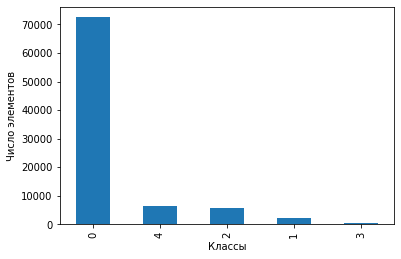

In [4]:
count_columns = len(test_data.iloc[0])
last_column_id = count_columns - 1

train_data[last_column_id] = train_data[last_column_id].astype(int)
test_data[last_column_id] = test_data[last_column_id].astype(int)

statistic = train_data[last_column_id].value_counts().plot(kind='bar', xlabel="Классы", ylabel="Число элементов")


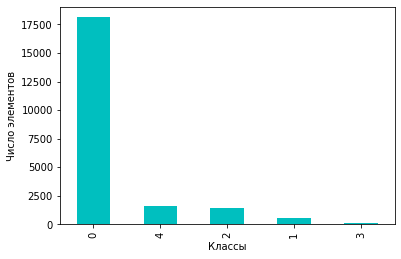

In [5]:
statistic = test_data[last_column_id].value_counts().plot(kind='bar', color="c", xlabel="Классы", ylabel="Число элементов")

In [6]:
train_values = train_data.values
test_values = test_data.values

In [7]:
X_train = train_values[:, :-1]
y_train = train_values[:, -1].astype(int)

X_test = test_values[:, :-1]
y_test = test_values[:, -1].astype(int)

In [8]:
class0, class1, class2, class3, class4 = get_classes_flatten(y_train)

In [9]:
from sklearn.model_selection import GridSearchCV

# For working of SVM and K-Neighbor Classifier
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_jobs=-1)
grid = GridSearchCV(clf, {'n_neighbors': range(1, 100)}, cv=5, verbose=1, n_jobs = -1)
knn = grid.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed: 40.4min finished


In [20]:
def draw_chart(clf, param, steps, x_label = "Значение параметра", y_label = "Точность", title = "График зависимости точности от выбранного параметра"):
    df = pd.DataFrame(clf.cv_results_)
    means = df['mean_test_score']
    stds = df['std_test_score']
    
    style.use('seaborn-poster') #sets the size of the charts
    style.use('ggplot')
    
    # Устанавливаем размер графика, наносим средние значения точности кросс-валидации и накидываем св. квадр. отклонение
    plt.figure(figsize=(20, 10))
    plt.plot(df['params'].apply(lambda x: x[param]), means)
    plt.fill_between(range(1, len(means) + 1), means + stds, means - stds, alpha = 0.5)
    
    # наносим значения на оси
    plt.xlim(1, len(means) + 1)
    plt.ylim(np.min(means - stds) - 0.05, np.max(means + stds) + 0.05)
    
    # Устанавливаем шаги, наносим сетку и подписываем оси с графиком
    plt.xticks(steps)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid()
    plt.show()

In [21]:
print("Лучший показатель в {} достигнут с параметрами {}"
      .format(knn.best_score_, knn.best_params_))

Лучший показатель в 0.9757292766061283 достигнут с параметрами {'n_neighbors': 1}


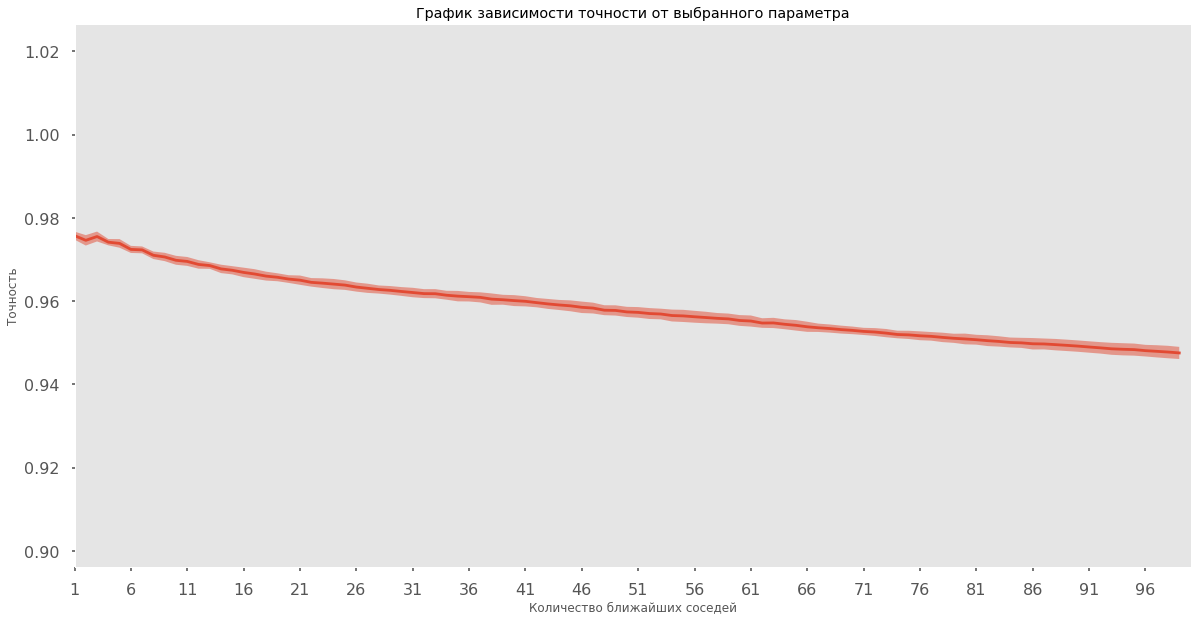

In [22]:
draw_chart(knn, 'n_neighbors', range(1, 100, 5), 'Количество ближайших соседей')

In [25]:
import time
start_time = time.time()
score_test = knn.score(X_test, y_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 22.291824340820312 seconds ---


In [23]:
score_test = knn.score(X_test, y_test)
print('Test Accuracy : ' + str(score_test))

Test Accuracy : 0.9762013520920885


In [9]:
from sklearn.model_selection import GridSearchCV

# For working of SVM and K-Neighbor Classifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

clf = SVC(kernel='poly', C=50.0)
grid = GridSearchCV(clf, {'degree': range(3, 4)}, cv = 3, verbose = 10, n_jobs = -1)
SVC_poly = grid.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  6.2min finished


In [10]:
print("Лучший показатель в {} достигнут с параметрами {}".format(SVC_poly.best_score_, SVC_poly.best_params_))

Лучший показатель в 0.9760833310321483 достигнут с параметрами {'degree': 3}


In [10]:
from sklearn.svm import SVC
clf = SVC(kernel='poly', C=50.0, degree=3)
clf.fit(X_train, y_train)

SVC(C=50.0, kernel='poly')

In [12]:
import time
start_time = time.time()
score_test = clf.score(X_test, y_test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 27.495290279388428 seconds ---


In [ ]:
import time
start_time = time.time()
score_test = SVC_poly.score(X_test, y_test)
print("--- %s seconds ---" % (time.time() - start_time))

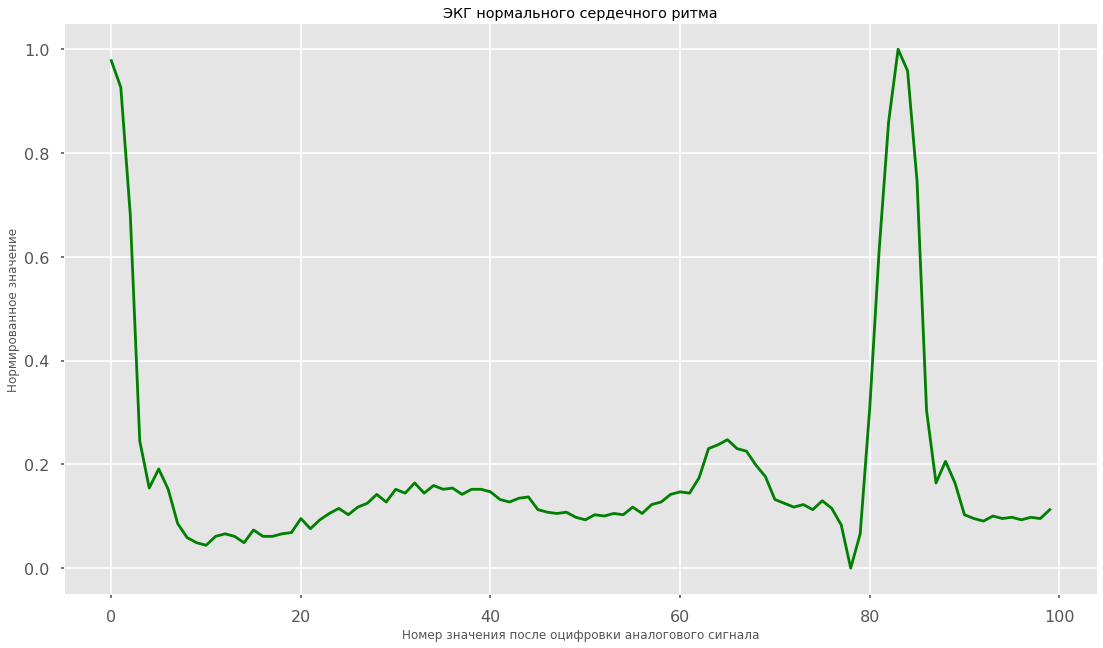

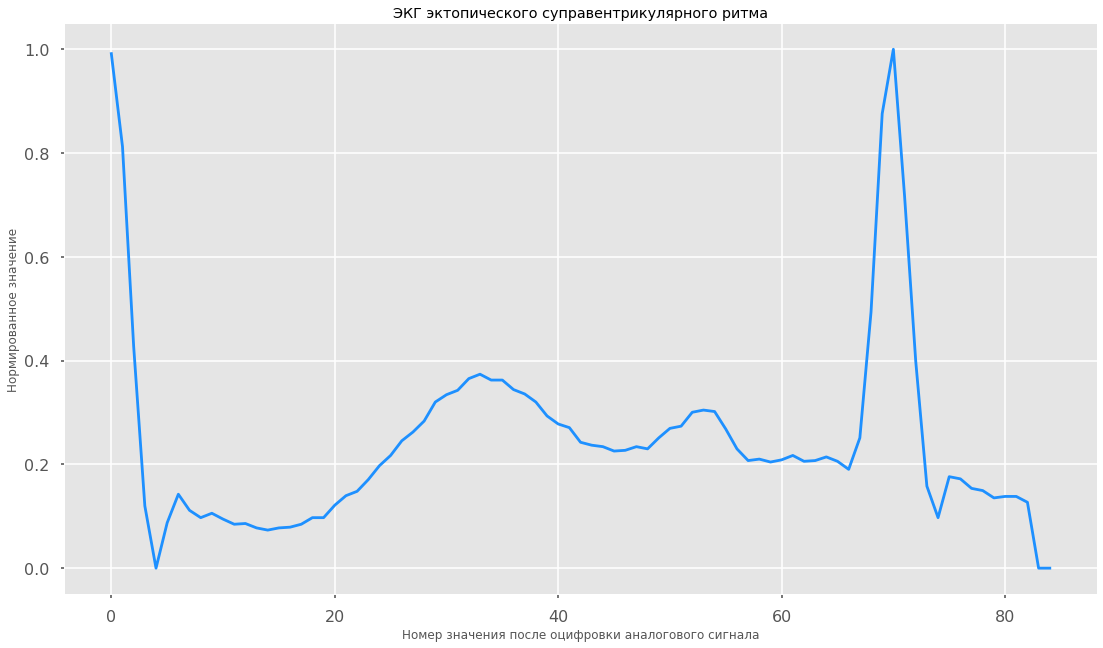

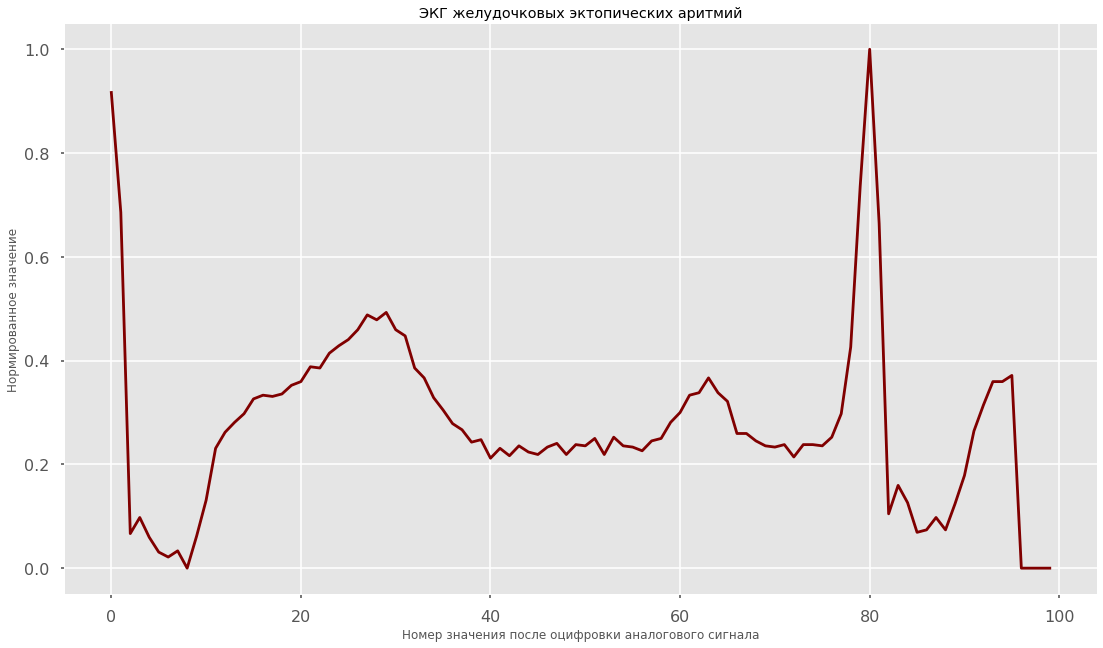

In [48]:
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(X_train[class0][0][:100], color="g")

plt.title('ЭКГ нормального сердечного ритма')
plt.ylabel('Нормированное значение')
plt.xlabel('Номер значения после оцифровки аналогового сигнала')
plt.show()

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(X_train[class1][0][:85], color="dodgerblue")

plt.title('ЭКГ эктопического суправентрикулярного ритма')
plt.ylabel('Нормированное значение')
plt.xlabel('Номер значения после оцифровки аналогового сигнала')
plt.show()

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(X_train[class2][2][:100], color="maroon")

plt.title('ЭКГ желудочковых эктопических аритмий')
plt.ylabel('Нормированное значение')
plt.xlabel('Номер значения после оцифровки аналогового сигнала')
plt.show()



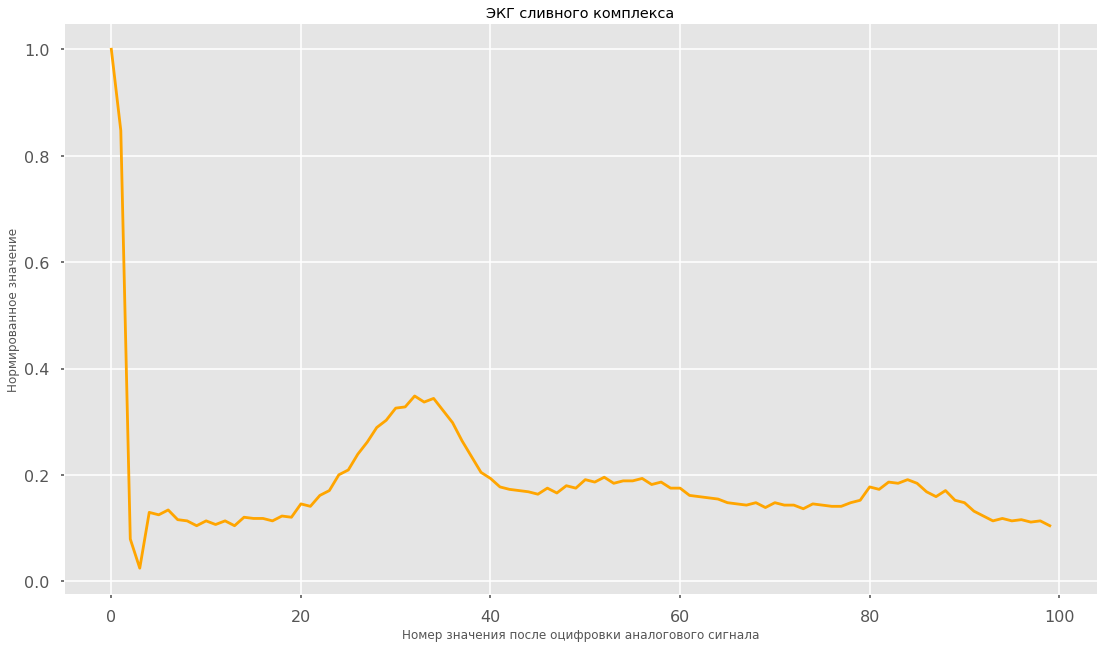

In [57]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(X_train[class3][5][:100], color="orange")

plt.title('ЭКГ сливного комплекса')
plt.ylabel('Нормированное значение')
plt.xlabel('Номер значения после оцифровки аналогового сигнала')
plt.show()

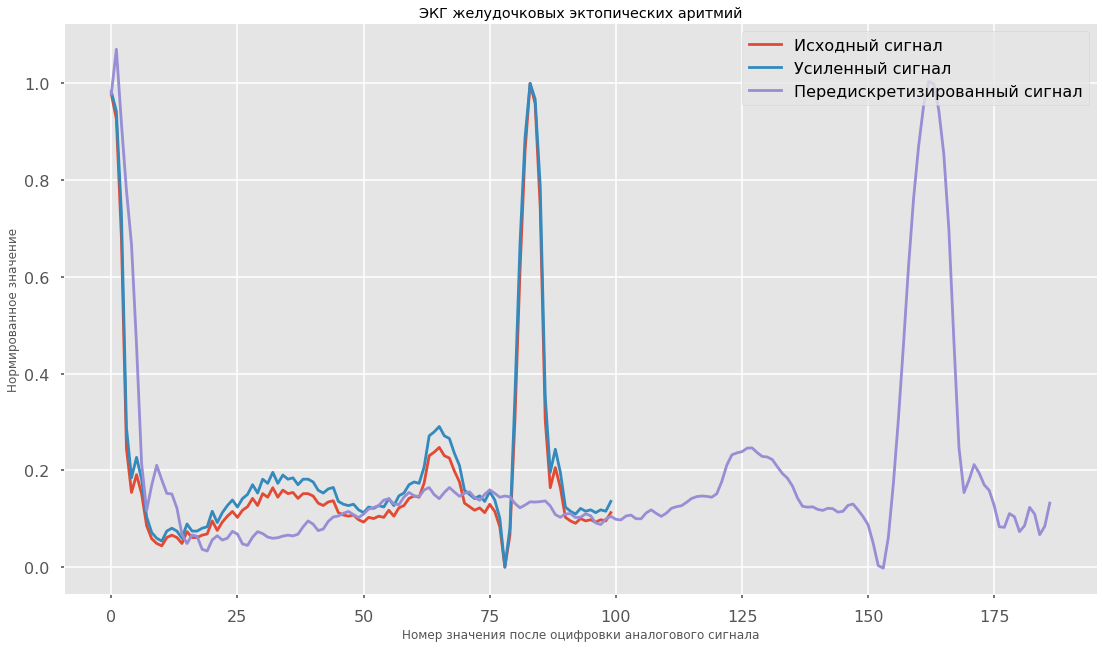

In [85]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(X_train[class0][0][:100])
plt.plot(get_amplify(X_train[class0][0][:100]))
plt.plot(get_stretch(X_train[class0][0][:100]))

plt.title('ЭКГ желудочковых эктопических аритмий')
plt.ylabel('Нормированное значение')
plt.xlabel('Номер значения после оцифровки аналогового сигнала')
plt.legend(['Исходный сигнал', 'Усиленный сигнал', 'Передискретизированный сигнал'], loc='upper right')
plt.show()

In [33]:
data1 = np.apply_along_axis(get_augment, axis=1, arr=X_train[class1]).reshape(-1, count_columns - 1)
data1_classes = np.ones(shape=(data1.shape[0],), dtype=int)*1

data3 = np.apply_along_axis(get_augment, axis=1, arr=X_train[class3]).reshape(-1, count_columns - 1)
data3_classes = np.ones(shape=(data3.shape[0],), dtype=int)*3

X_train_aug = np.vstack([X_train, data1, data3])
y_train_aug = np.hstack([y_train, data1_classes, data3_classes])

In [169]:
count_columns = 188 # previous ipynb (187 + label)
random_size = 150 # random

one_hot_encoder = OneHotEncoder()

In [170]:
X_train = np.expand_dims(X_train, 2)
X_train_aug = np.expand_dims(X_train_aug, 2)
X_test = np.expand_dims(X_test, 2)

y_train = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_train_aug = one_hot_encoder.fit_transform(y_train_aug.reshape(-1, 1))
y_test = one_hot_encoder.transform(y_test.reshape(-1, 1))

In [171]:
def plot_confusion_matrix(confusion_matrix, classes, normalize=False):    
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    threshold = confusion_matrix.max() / 2.
    
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [172]:
# Build model

In [173]:
def my_exp(epoch):
    initial_lrate = 0.001
    k = 0.40
    t = n_objects // (10000 * 500) 
    learning_rate = initial_lrate * math.exp(-k * t)
    return learning_rate

learning_rate = LearningRateScheduler(my_exp)
adam_optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [174]:
from keras.layers.pooling import GlobalMaxPooling1D

def build_keras_model():   
    
    K.clear_session()

    input0 = Input(shape=(fic, dep))
    cntn = Conv1D(filters=64, kernel_size=k_size, strides=strides_small) (input0)

    cntn1_it1 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(cntn)
    actn1_it1 = Activation("relu")(cntn1_it1)
    
    cntn2_it1 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(actn1_it1)
    adg_1 = Concatenate(axis=1)([cntn2_it1, cntn])
    actn2_it1 = Activation("relu")(adg_1)
    
    max_pooling_1 = MaxPooling1D(pool_size=k_size, strides=strides_big)(actn2_it1)


    cntn1_it2 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(max_pooling_1)
    actn1_it2 = Activation("relu")(cntn1_it2)
    
    cntn2_it2 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(actn1_it2)
    adg_2 = Concatenate(axis=1)([cntn2_it2, max_pooling_1])
    actn2_it2 = Activation("relu")(adg_1)
    
    max_pooling_2 = MaxPooling1D(pool_size=k_size, strides=strides_big)(actn2_it2)


    cntn1_it3 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(max_pooling_2)
    actn1_it3 = Activation("relu")(cntn1_it3)
    
    cntn2_it3 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(actn1_it3)
    adg_3 = Concatenate(axis=1)([cntn2_it3, max_pooling_2])
    actn2_it3 = Activation("relu")(adg_3)
    
    max_pooling_3 = MaxPooling1D(pool_size=k_size, strides=strides_big)(actn2_it3)


    cntn1_it4 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(max_pooling_3)
    actn1_it4 = Activation("relu")(cntn1_it4)
    
    cntn2_it4 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(actn1_it4)
    adg_4 = Concatenate(axis=1)([cntn2_it4, max_pooling_3])
    actn2_it4 = Activation("relu")(adg_4)
    
    max_pooling_4 = MaxPooling1D(pool_size=k_size, strides=strides_big)(actn2_it4)


    cntn1_it5 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(max_pooling_4)
    actn1_it5 = Activation("relu")(cntn1_it5)
    
    cntn2_it5 = Conv1D(filters=64, kernel_size=k_size, strides=strides_small, padding='same')(actn1_it5)
    adg_5 = Concatenate(axis=1)([cntn2_it5, max_pooling_4])
    actn2_it5 = Activation("relu")(adg_5)
    
    max_pooling_5 = MaxPooling1D(pool_size=k_size, strides=strides_big)(actn2_it5)

    result_flatten = Flatten()(max_pooling_5)

    dense = Dense(64)(result_flatten)
    actn_result = Activation("relu")(dense)
    dense_prefinal = Dense(64)(actn_result)
    dense_final = Dense(5)(dense_prefinal)
    output0 = Softmax()(dense_final)

    model = Model(inputs=input0, outputs=output0)

    return model

In [175]:
model = build_keras_model()

In [176]:
# Run
model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

In [177]:
history = model.fit(X_train_aug,
                    y_train_aug,
                    epochs=100,
                    batch_size=2000,
                    verbose=2,
                    validation_data=(X_test, y_test), callbacks=[learning_rate])
                   

Train on 99010 samples, validate on 21892 samples
Epoch 1/100
 - 7s - loss: 0.7032 - accuracy: 0.7734 - val_loss: 0.2627 - val_accuracy: 0.9349
Epoch 2/100
 - 6s - loss: 0.3022 - accuracy: 0.9037 - val_loss: 0.1724 - val_accuracy: 0.9538
Epoch 3/100
 - 6s - loss: 0.2058 - accuracy: 0.9338 - val_loss: 0.1158 - val_accuracy: 0.9667
Epoch 4/100
 - 6s - loss: 0.2060 - accuracy: 0.9354 - val_loss: 0.1036 - val_accuracy: 0.9699
Epoch 5/100
 - 6s - loss: 0.1418 - accuracy: 0.9531 - val_loss: 0.0965 - val_accuracy: 0.9726
Epoch 6/100
 - 6s - loss: 0.1218 - accuracy: 0.9598 - val_loss: 0.0939 - val_accuracy: 0.9734
Epoch 7/100
 - 6s - loss: 0.1098 - accuracy: 0.9635 - val_loss: 0.0734 - val_accuracy: 0.9794
Epoch 8/100
 - 6s - loss: 0.0866 - accuracy: 0.9706 - val_loss: 0.0729 - val_accuracy: 0.9790
Epoch 9/100
 - 6s - loss: 0.0836 - accuracy: 0.9716 - val_loss: 0.0827 - val_accuracy: 0.9746
Epoch 10/100
 - 6s - loss: 0.0712 - accuracy: 0.9755 - val_loss: 0.0673 - val_accuracy: 0.9800
Epoch 11/

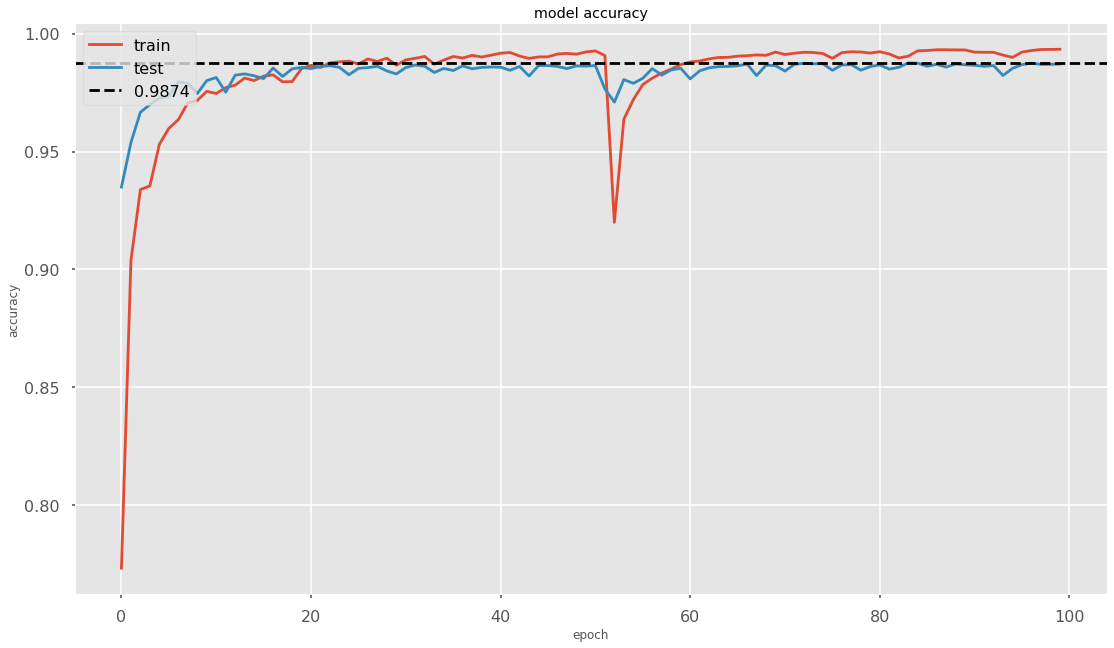

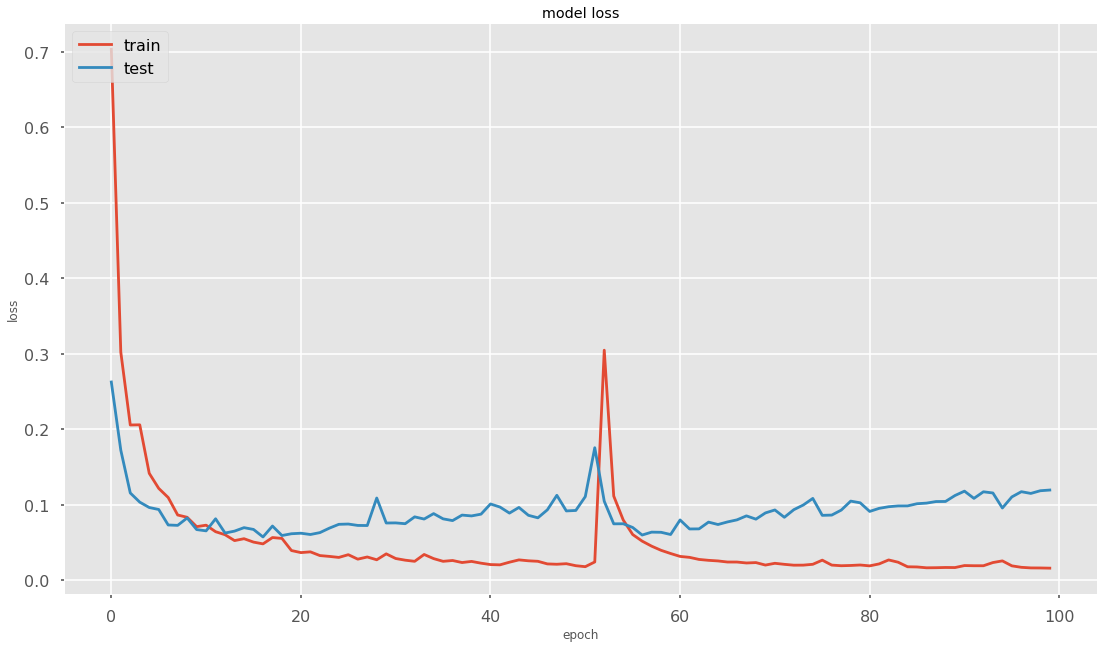

In [214]:
import matplotlib.style as style

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axhline(y=0.9874, color="black", linestyle="--", label="")

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test', "0.9874"], loc='upper left')
plt.show()

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [216]:
y_pred = model.predict(X_test, batch_size=2000)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print("Ranking-based prec avg: {:.3f}".format(label_ranking_average_precision_score(y_test.todense(), y_pred)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.89      0.84      0.86       556
           2       0.97      0.96      0.97      1448
           3       0.81      0.81      0.81       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.93      0.92      0.93     21892
weighted avg       0.99      0.99      0.99     21892

Ranking-based prec avg: 0.993


Normalized confusion matrix


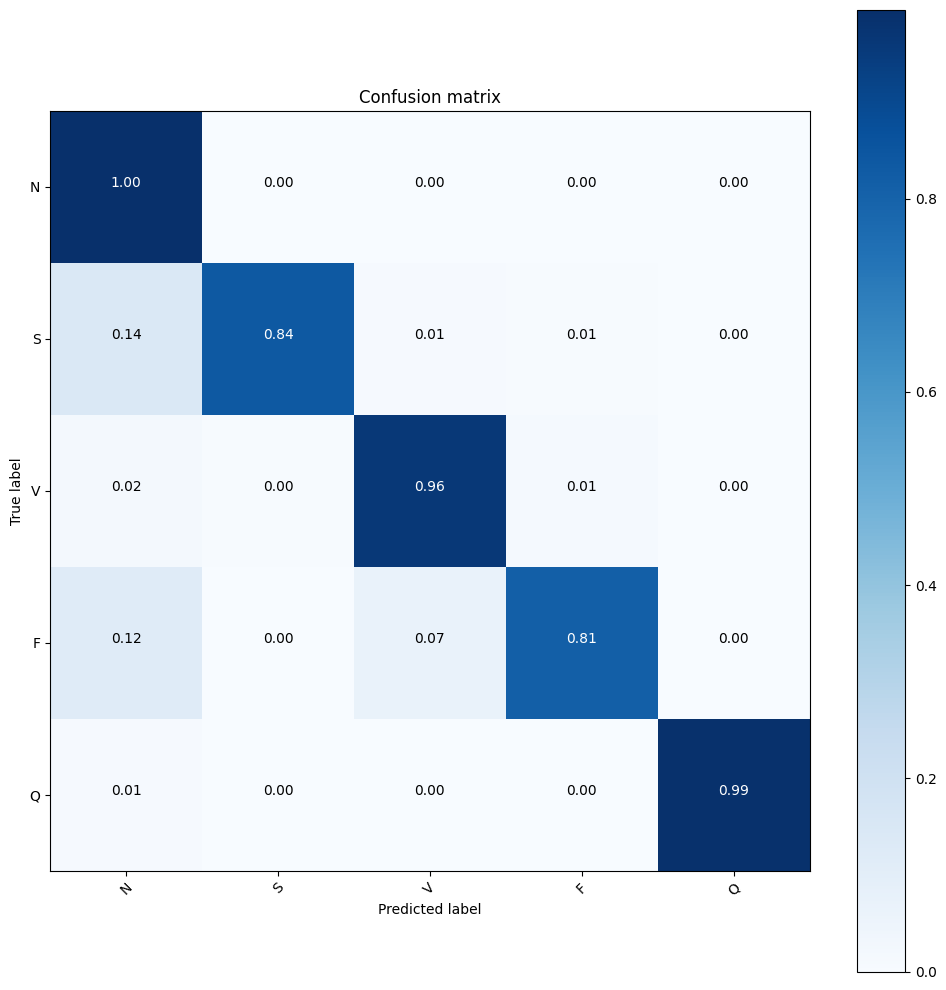

In [217]:
plt.rcParams.update(plt.rcParamsDefault)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

np.set_printoptions(precision=2)
plt.figure(figsize=(10, 10))

plot_confusion_matrix(cnf_matrix, classes=['N', 'S', '', 'F', 'Q'], normalize=True)
plt.show()